# Anime Recommender with Bi-partite Graph Network
> Loading Anime dataset from Kaggle and building bipartite graph using NetworkX, then finding similar users and recommending animes to the target user

- toc: true
- badges: true
- comments: true
- categories: [Anime, GraphNetwork]
- author: "<a href='https://github.com/RohanBera/Recommendation-system'>Rohan Bera</a>"
- image:

In [1]:
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt

## Some terminology

User looking for recommendation: **Main user** <br/>
Other users: **Other users/ users**

## Finding relations between users 

We will generate relationships (weights) between the main user and other users. The suggestions/ratings of a user having a better relationship with main user will have more weightage over that of other users. <br />
The relationship will be denotated by a directed edge from the main user to the other user.

In [2]:
def relationship_among_users(G, user, deg):
    '''
        description:
            given main user, add weighted edges between 
            main user and other users based on common nodes
    
        parameters:
            G: the bipartite graph (directed, weighted)
            user: user who is looking for recommendations (main user)
            deg: no. of anime main user has reviwed

        returns: 
            void
    '''

    u = user

    for w in users:
        weight = 0.0
        for v in G.neighbors(u): 
            if G.nodes[v]['label'] == 'anime' and G.has_edge(w, v):
                weight += (1/G.out_degree(v))

        weight /= deg

        if (weight != 0):
            G.add_edge(u, w, weight=weight) 

## Recommended anime list

Based on main user's relationships and the ratings given to anime by other users, a list of anime_ids is returned in sorted order (most recommended anime first)

In [3]:
def recommendation_list(G, user, deg, include_already_watched=False, top_n=None):
    '''
        description: 
            Given a graph with connections (weghted, directed) among users
            and the user who needs recommendations,
            returns sorted list of recommended animes 

        parameters:
            G: Graphs with connection among users 
                (graph after implementing 'relationship_among_users()')
            user: User who is looking for recommendations (main user)
            deg: number of anime main user has reviewed
            include_already_watched: (default = false)
                if true, the list of anime main user has already watched will 
                also be included in the recommendation list
            top_n: (default = None)
                returns only the 'top_n' animes

        returns: 
            sorted list of recommended anime
                eg. [(anime1, score1), (anime2, score2), (anime3, score3)]
    '''

    u = user
    possible_anime = set()

    for n in G.neighbors(u):
        if G.nodes[n]['label'] == 'anime':
            for other_users in G.neighbors(n):
                for anime in G.neighbors(other_users):
                    if G.nodes[anime]['label'] == 'anime':
                        possible_anime.add(anime)

    suggestion_dict = {}

    for anime in possible_anime:
        score = 0
        for w in G.neighbors(anime):
            if G.has_edge(u, w):
                # score += (G[u][w]['weight'] * G[w][anime]['rating'] / (deg if w==u else G.out_degree(w)))
                score += (G[u][w]['weight'] * (1 - 1/G[w][anime]['rating'] )/ (deg if w==u else G.out_degree(w)))

        suggestion_dict[anime] = score

    # remove already watched anime
    if not include_already_watched:
        for already_watched in G.neighbors(u):
            if G.nodes[already_watched]['label'] == 'anime':
                del suggestion_dict[already_watched]

    return sorted(list(suggestion_dict.items()), key=(lambda x : x[1]), reverse=True)[:top_n]


## Fetch anime title

Based on the ids returned in 'recommendation_list()' function, the respective anime titles and plots are returned.

## Testing

Let us try the above algorithms over a small network to understand how it works.

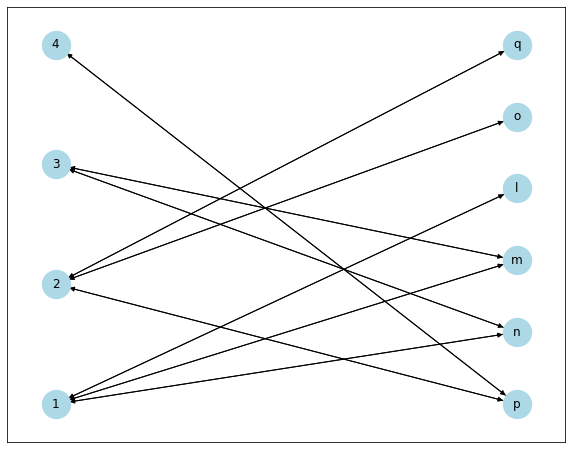


weights among users: {(4, 2): 0.5, (4, 4): 0.5}



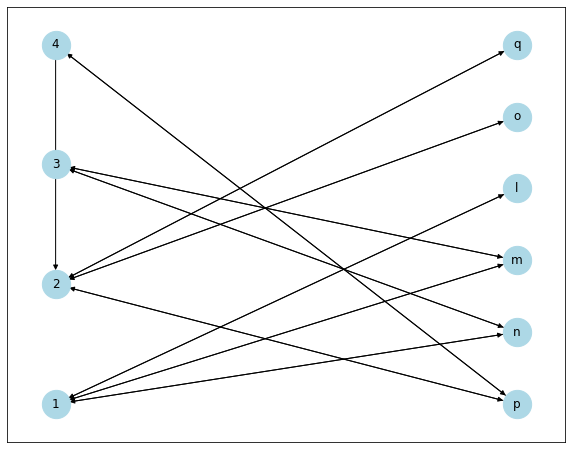


Recommended list of anime ids: [('o', 0.125), ('q', 0.125)]



In [6]:
G = nx.Graph()

users = [1,2,3,4]
anime = ['l','m','n','o','p','q']

G.add_nodes_from(users, label='user')
G.add_nodes_from(anime, label='anime')

# pattern - user 1 and 3 are similar, user 2 and 4 are similar
G.add_edges_from([(1, 'l', {'rating' : 4}), 
                  (1, 'm', {'rating' : 5}),
                  (1, 'n', {'rating' : 4}),
                  (2, 'o', {'rating' : 4}),
                  (2, 'p', {'rating' : 5}),
                  (2, 'q', {'rating' : 4}),
                  (3, 'm', {'rating' : 5}),
                  (3, 'n', {'rating' : 5}),
                  (4, 'p', {'rating' : 4}),
                  ])

main_user = 4
deg = G.degree(main_user)

G = nx.DiGraph(G)

pos = nx.bipartite_layout(G, users)

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
plt.show()

# generating relationships among users
relationship_among_users(G, main_user, deg)

edge_weights = nx.get_edge_attributes(G, 'weight')
print('\n===================================')
print('weights among users:', edge_weights)
print('===================================\n')

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_weights)
plt.show()

#getting the recommended list of anime ids
recommended_anime_ids = recommendation_list(G, main_user, deg)

print('\n===================================')
print('Recommended list of anime ids:', recommended_anime_ids)
print('===================================\n')


## Actual data

Lets try it on our actual data now. 

user ratings dataset: https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv
> (contains ratings given by various users to anime)

anime dataset: https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=anime.csv

> (contains list of anime)

I made some changes to the dataset
1. Added a prefix 'a' to the anime_ids (and MAL_IDS) so they dont mix up with the user_ids
2. Added my anime ratings with user_id = -1
3. I used only the top 500000 rows as the process is time consuming

In [ ]:
# anime data (anime.csv)
anime_data = pd.read_csv('anime.csv')
anime_data['MAL_ID'] = 'a' + anime_data['MAL_ID'].astype(int).astype(str)
anime_data = anime_data.rename(columns={'Score' : 'Community rating'})

# user ratings data (rating_complete.csv)
data = pd.read_csv('rating_complete.csv', nrows=500000)
data['anime_id'] = 'a' + data['anime_id'].astype(int).astype(str)
data_users = data['user_id']
data_anime = data['anime_id']

# lets look at my anime list and ratings
pd.set_option('display.max_rows', None)
temp = pd.merge(data, anime_data, left_on='anime_id', right_on='MAL_ID')[['user_id', 'anime_id', 'Name', 'English name', 'rating', 'Community rating']]
display(temp[temp['user_id'] == -1])

# Given MAL_ID, fetches the anime details
anime_data = anime_data.set_index('MAL_ID')
def fetch_anime_titles(anime_list):
    return  anime_data.loc[anime_list][['Name', 'English name', 'Genres', 'Community rating']]

,user_id,anime_id,Name,English name,rating,Community rating
0,-1,a1535,Death Note,Death Note,8,8.63
1674,-1,a1575,Code Geass: Hangyaku no Lelouch,Code Geass:Lelouch of the Rebellion,10,8.72
2948,-1,a1953,Code Geass: Hangyaku no Lelouch Picture Drama,Code Geass:Lelouch of the Rebellion Picture Dr...,10,6.97
3016,-1,a15197,Code Geass: Boukoku no Akito 2 - Hikisakareshi...,Code Geass:Akito the Exiled - The Wyvern Divided,9,7.54
3138,-1,a15199,Code Geass: Boukoku no Akito 3 - Kagayaku Mono...,Code Geass:Akito the Exiled - The Brightness F...,9,7.33
3222,-1,a15201,Code Geass: Boukoku no Akito 4 - Nikushimi no ...,Code Geass:Akito the Exiled - Memories of Hatred,9,7.27
3300,-1,a20,Naruto,Naruto,8,7.91
4464,-1,a1735,Naruto: Shippuuden,Naruto:Shippuden,8,8.16
4987,-1,a32182,Mob Psycho 100,Mob Psycho 100,8,8.49
5710,-1,a20583,Haikyuu!!,Haikyu!!,8,8.53


In [ ]:
# Generating the graph

G = nx.Graph()
G = nx.from_pandas_edgelist(data, 'user_id', 'anime_id', edge_attr='rating')

G.add_nodes_from(data_users, label='user')
G.add_nodes_from(data_anime, label='anime')

main_user = -1
deg = G.degree(main_user)
print(deg)

G = nx.DiGraph(G)

## plotting the graph takes a lot of time

# pos = nx.bipartite_layout(G, data_users)
# plt.figure(figsize=(50, 40))
# # nx.draw_networkx(G, pos=pos, node_size=100, node_color='lightblue', edge_color='grey' with_labels=False)
# nx.draw_networkx(G, node_size=1000, node_color='lightblue', edge_color='grey', with_labels=False)
# plt.show()


64


In [ ]:
# generating relationships among users
relationship_among_users(G, main_user, deg)

edge_weights = nx.get_edge_attributes(G, 'weight')
print('\n===================================')
print('weights among users:', edge_weights)
print('===================================\n')

## plotting the graph takes a lot of time

# plt.figure(figsize=(10, 8))
# nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_weights)
# plt.show()

#getting the recommended list of anime ids
recommended_anime_scores = recommendation_list(G, user=main_user, deg=deg, top_n=20)

print('\n===================================')
print('Recommended list of anime ids and their calculated scores: ', recommended_anime_scores)
print('===================================\n')

recommended_anime_ids = [ pair[0] for pair in recommended_anime_scores]

# fetch anime information from their ids
fetch_anime_titles(recommended_anime_ids)


weights among users: {(-1, 1): 0.0008864565435448475, (-1, 2): 0.00026534672405055694, (-1, 3): 8.439037029079238e-05}


Recommended list of anime ids and their calculated scores:  [('a9253', 1.2608654903454946e-05), ('a28171', 1.2389774632427958e-05), ('a11061', 1.2332699656105028e-05), ('a34599', 1.1990186240599003e-05), ('a37450', 7.983875399305805e-06), ('a32281', 7.983875399305805e-06), ('a23273', 7.884528103406225e-06), ('a4224', 7.884528103406225e-06), ('a31043', 7.879744068809242e-06), ('a37497', 7.768716044076472e-06), ('a31240', 7.768716044076472e-06), ('a35788', 7.768716044076472e-06), ('a14813', 7.764995128278819e-06), ('a23847', 7.764995128278819e-06), ('a19815', 7.764995128278819e-06), ('a5081', 7.764995128278819e-06), ('a32282', 7.764995128278819e-06), ('a9919', 7.764995128278819e-06), ('a32188', 7.74573678825595e-06), ('a199', 7.74573678825595e-06)]



,Name,English name,Genres,Community rating
MAL_ID,,,,
a9253,Steins;Gate,Steins;Gate,"Thriller, Sci-Fi",9.11
a28171,Shokugeki no Souma,Food Wars! Shokugeki no Soma,"Ecchi, School, Shounen",8.29
a11061,Hunter x Hunter (2011),Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power",9.1
a34599,Made in Abyss,Made in Abyss,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",8.74
a37450,Seishun Buta Yarou wa Bunny Girl Senpai no Yum...,Rascal Does Not Dream of Bunny Girl Senpai,"Comedy, Supernatural, Drama, Romance, School",8.38
a32281,Kimi no Na wa.,Your Name.,"Romance, Supernatural, School, Drama",8.96
a23273,Shigatsu wa Kimi no Uso,Your Lie in April,"Drama, Music, Romance, School, Shounen",8.74
a4224,Toradora!,Toradora!,"Slice of Life, Comedy, Romance, School",8.24
a31043,Boku dake ga Inai Machi,ERASED,"Mystery, Psychological, Supernatural, Seinen",8.37
